# Описание проектра
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Откроем файлы с данными и изучимобщую информацию. 

#### Необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
pd.options.mode.chained_assignment = None

#### Звонки

In [2]:
calls=pd.read_csv('/datasets/calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


#### Интернет

In [4]:
internet=pd.read_csv('/datasets/internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


#### Сообщения

In [6]:
messages=pd.read_csv('/datasets/messages.csv')
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


#### Тарифы

In [8]:
tariffs=pd.read_csv('/datasets/tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Позьзователи

In [10]:
users=pd.read_csv('/datasets/users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


По этим данным можно заметить некоторые ошибки, которые исправим в след. шаге:  
1. calls - длительность звонка 0 (возможно пропущенные вызовы), сделаем таблицу без 0 значений  
2. internet - неизвестный столбец, удалим его(возможно данные уже были пронумерованны)  
3. Все даты переведем в тип datetime64  
4. user_id переведем в тип str


### Шаг 2. Подготовим данные
#### Интернет


In [12]:
internet=internet.drop(columns='Unnamed: 0')

In [13]:
columns_name={'session_date':'datetime64',
              'user_id':str
             }
internet=internet.astype(columns_name)

In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.6+ MB


#### Сообщения

In [15]:
messages['user_id']=messages['user_id'].astype(str)

In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null object
dtypes: object(3)
memory usage: 2.8+ MB


#### Звонки

In [17]:
calls_main=calls.loc[calls['duration']>0]
calls_main['user_id']=calls_main['user_id'].astype(str)
calls_main

,id,call_date,duration,user_id
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


#### Пользователи

In [18]:
columns_name={'churn_date':'datetime64',
              'user_id':str,'reg_date':'datetime64'
             }
users=users.astype(columns_name)

In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null object
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


Мы подготовили данные для дальнейшего анализа.


#### Посчитаем для каждого пользователя:  
- количество сделанных звонков и израсходованных минут разговора по месяцам;  
- количество отправленных сообщений по месяцам;  
- объем израсходованного интернет-трафика по месяцам;  
- помесячную выручку с каждого пользователя;  
- остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

##### Количество сделанных звонков и израсходованных минут разговора по месяцам;

Округлим значения в верхнюю сторону, тк «Мегалайн» всегда округляет вверх значения минут и мегабайтов и добавим колонку месяцев

In [20]:

calls_main['duration_round']=calls_main['duration'].apply(math.ceil)
calls_main['month']=pd.DatetimeIndex(calls_main['call_date']).month
calls_main

,id,call_date,duration,user_id,duration_round,month
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12
7,1000_7,2018-08-22,18.31,1000,19,8
8,1000_8,2018-09-15,18.44,1000,19,9
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,1,12
202603,1499_216,2018-10-18,18.83,1499,19,10
202604,1499_217,2018-11-10,10.81,1499,11,11
202605,1499_218,2018-10-06,4.27,1499,5,10


Создадим отдельную таблицу с количеством сделанных звонков и израсходованных минут разговора по месяцам и присоединим ее к таблице calls

In [21]:
calls_info=calls_main.groupby(['user_id','month']).agg({'duration_round':'sum','id':"count"})
calls_info.columns=['duration_sum_per_month','calls_count_per_month']
calls_info

duration_sum_per_month  calls_count_per_month
user_id month                                               
1000    5                         159                     17
        6                         172                     28
        7                         340                     41
        8                         408                     42
        9                         466                     46
...                               ...                    ...
1498    10                        247                     30
1499    9                          70                      8
        10                        449                     44
        11                        612                     62
        12                        492                     56

[3168 rows x 2 columns]

##### Количество отправленных сообщений по месяцам;

Проведем аналогичные действия с сообщениями

In [22]:
messages['month']=pd.DatetimeIndex(messages['message_date']).month
messages_info=messages.groupby(['user_id','month']).agg({'id':'count'})
messages_info.columns=['messages_count']
messages_info

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

Проведем аналогичные действия с интернетом

In [23]:
internet['month']=pd.DatetimeIndex(internet['session_date']).month
internet['mb_used']=internet['mb_used'].apply(math.ceil)
internet_info=internet.groupby(['user_id','month']).agg({'mb_used':'sum'})
internet_info.columns=['mb_count']
internet_info

mb_count
user_id month          
1000    5          2256
        6         23257
        7         14016
        8         14070
        9         14581
...                 ...
1498    10        20604
1499    9          1848
        10        17809
        11        17984
        12        13077

[3203 rows x 1 columns]

In [24]:
data=internet_info.merge(messages_info,on=['user_id','month'],how='left')
data

mb_count  messages_count
user_id month                          
1000    5          2256            22.0
        6         23257            60.0
        7         14016            75.0
        8         14070            81.0
        9         14581            57.0
...                 ...             ...
1498    10        20604            42.0
1499    9          1848            11.0
        10        17809            48.0
        11        17984            59.0
        12        13077            66.0

[3203 rows x 2 columns]

##### Объединение столбцов в один


Соединим все таблицы в одну, для удобства работы. Добавим к ней название тарифа.

In [25]:
data=data.merge(calls_info,on=['user_id','month'])


In [26]:
data=data.merge(users.loc[:,['user_id','tariff','city']],on='user_id')

In [27]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<a name="1"></a>

In [28]:
data

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff,city
0,1000,2256,22.0,159,17,ultra,Краснодар
1,1000,23257,60.0,172,28,ultra,Краснодар
2,1000,14016,75.0,340,41,ultra,Краснодар
3,1000,14070,81.0,408,42,ultra,Краснодар
4,1000,14581,57.0,466,46,ultra,Краснодар
...,...,...,...,...,...,...,...
3152,1498,20604,42.0,247,30,smart,Владикавказ
3153,1499,1848,11.0,70,8,smart,Пермь
3154,1499,17809,48.0,449,44,smart,Пермь
3155,1499,17984,59.0,612,62,smart,Пермь


Создадим вспомогательную таблицу для расчета прибыли по каждому пользователю 

In [29]:
data_total=data.rename(columns={'tariff': 'tariff_name'}, inplace=False)

In [30]:
data_total=data_total.merge(tariffs,on='tariff_name')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3157 entries, 0 to 3156
Data columns (total 7 columns):
user_id                   3157 non-null object
mb_count                  3157 non-null int64
messages_count            2662 non-null float64
duration_sum_per_month    3157 non-null int64
calls_count_per_month     3157 non-null int64
tariff                    3157 non-null object
city                      3157 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 197.3+ KB


In [31]:
data_total

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2256,22.0,159,17,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,23257,60.0,172,28,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,14016,75.0,340,41,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,14070,81.0,408,42,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,14581,57.0,466,46,ultra,Краснодар,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,1498,20604,42.0,247,30,smart,Владикавказ,50,15360,500,550,200,3,3
3153,1499,1848,11.0,70,8,smart,Пермь,50,15360,500,550,200,3,3
3154,1499,17809,48.0,449,44,smart,Пермь,50,15360,500,550,200,3,3
3155,1499,17984,59.0,612,62,smart,Пермь,50,15360,500,550,200,3,3


В этом цикле мы рассчитываем прибль по звонкам, сообщениям, интернету отдельно, и добаляем в data['profit']- общая прибль за месяц с пользователя  
(будем мержить немного странным образом ( при обыкновенном приравнивании столбцов data и data_total появляется одно несоответствующее значение "1 смарту соотв. цена за ультра", однако совпадение и user_id и mb_count невозможно (высокая точность подсчета mb_count). Таким подходом все получается.

In [32]:
row=[['messages_save','messages_count','messages_included','rub_per_message','profit_from_message','profit_from_message'],
     ['min_save','duration_sum_per_month','minutes_included','rub_per_minute','profit_from_calls','profit_from_calls'],
     ['mb_save','mb_count','mb_per_month_included','rub_per_gb','data_gb','profit_from_internet','profit_from_internet']]

data=data.merge(data_total.loc[:,['user_id','mb_count','rub_monthly_fee']],on=['user_id','mb_count'])

for i in row:
    data_total[i[0]]=data_total[i[1]]-data_total[i[2]]
    data_total.loc[data_total[i[0]]<0,i[0]]=0
    if i[0]=='mb_save':
        data_total[i[4]]=(data_total[i[0]]/1024)
        data_total[i[4]]=data_total[i[4]].apply(math.ceil)
        data_total[i[6]]=data_total[i[4]]*data_total[i[3]]
        data=data.merge(data_total.loc[:,['user_id','mb_count',i[6]]],on=['user_id','mb_count'])
        
    else:
        data_total.loc[data_total[i[0]]<0,i[0]]=0
        data_total[i[5]]=data_total[i[0]]*data_total[i[3]]
        data=data.merge(data_total.loc[:,['user_id','mb_count',i[5]]],on=['user_id','mb_count'])
data['messages_count']=data['messages_count'].fillna(0)
data['profit_from_message']=data['profit_from_message'].fillna(0)
data['profit']=data['rub_monthly_fee']+data['profit_from_message']+data['profit_from_calls']+data['profit_from_internet']

Получили такую таблицу:

In [33]:
data

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff,city,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
0,1000,2256,22.0,159,17,ultra,Краснодар,1950,0.0,0,0,1950.0
1,1000,23257,60.0,172,28,ultra,Краснодар,1950,0.0,0,0,1950.0
2,1000,14016,75.0,340,41,ultra,Краснодар,1950,0.0,0,0,1950.0
3,1000,14070,81.0,408,42,ultra,Краснодар,1950,0.0,0,0,1950.0
4,1000,14581,57.0,466,46,ultra,Краснодар,1950,0.0,0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3182,1498,20604,42.0,247,30,smart,Владикавказ,550,0.0,0,1200,1750.0
3183,1499,1848,11.0,70,8,smart,Пермь,550,0.0,0,0,550.0
3184,1499,17809,48.0,449,44,smart,Пермь,550,0.0,0,600,1150.0
3185,1499,17984,59.0,612,62,smart,Пермь,550,27.0,336,600,1513.0


<a name="2"></a>

### Шаг 3. Проанализируем данные

Создадим две таблицы с одинаковыми тарифами

In [34]:
data_ultra=data[data['tariff'] == 'ultra']
data_smart=data[data['tariff'] == 'smart']
data_ultra.head(5)

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff,city,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
0,1000,2256,22.0,159,17,ultra,Краснодар,1950,0.0,0,0,1950.0
1,1000,23257,60.0,172,28,ultra,Краснодар,1950,0.0,0,0,1950.0
2,1000,14016,75.0,340,41,ultra,Краснодар,1950,0.0,0,0,1950.0
3,1000,14070,81.0,408,42,ultra,Краснодар,1950,0.0,0,0,1950.0
4,1000,14581,57.0,466,46,ultra,Краснодар,1950,0.0,0,0,1950.0


In [35]:
data_smart.head(5)

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff,city,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
8,1001,18452,0.0,430,45,smart,Москва,550,0.0,0,800,1350.0
9,1001,14053,0.0,414,47,smart,Москва,550,0.0,0,0,550.0
10,1002,10871,4.0,117,14,smart,Стерлитамак,550,0.0,0,0,550.0
11,1002,17601,11.0,214,21,smart,Стерлитамак,550,0.0,0,600,1150.0
12,1002,20347,13.0,289,37,smart,Стерлитамак,550,0.0,0,1000,1550.0


Заметим, что в количестве сообщений есть NaN, что означает, что сообщений 0  
Посмотрим анализ пользователей smart

In [36]:
data_smart.describe()

,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
count,2220.000000,2220.000000,2220.000000,2220.000000,2220.0,2220.000000,2220.000000,2220.000000,2220.000000
mean,16238.773874,33.406757,419.606757,47.136036,550.0,17.470270,125.322973,603.333333,1296.126577
std,5874.671624,28.268236,188.872151,20.871729,0.0,40.393809,254.425716,740.368632,821.880594
min,0.000000,0.000000,2.000000,1.000000,550.0,0.000000,0.000000,0.000000,550.000000
25%,12679.500000,10.000000,285.000000,32.000000,550.0,0.000000,0.000000,0.000000,550.000000
50%,16529.000000,28.000000,423.000000,48.000000,550.0,0.000000,0.000000,400.000000,1039.000000
75%,20071.000000,51.000000,546.000000,61.000000,550.0,3.000000,138.000000,1000.000000,1750.000000
max,38610.000000,143.000000,1435.000000,162.000000,550.0,279.000000,2805.000000,4600.000000,6770.000000


Посмотрим анализ пользователей ultra

In [37]:
data_ultra.describe()

,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
count,967.000000,967.000000,967.000000,967.000000,967.0,967.0,967.0,967.000000,967.000000
mean,19752.533609,49.263702,559.013444,63.038263,1950.0,0.0,0.0,119.906929,2069.906929
std,9836.256243,46.080290,303.521940,34.145068,0.0,0.0,0.0,379.248592,379.248592
min,0.000000,0.000000,1.000000,1.000000,1950.0,0.0,0.0,0.000000,1950.000000
25%,12225.500000,6.000000,327.000000,37.000000,1950.0,0.0,0.0,0.000000,1950.000000
50%,19707.000000,41.000000,542.000000,62.000000,1950.0,0.0,0.0,0.000000,1950.000000
75%,26722.500000,78.000000,785.000000,88.000000,1950.0,0.0,0.0,0.000000,1950.000000
max,49789.000000,224.000000,1673.000000,190.000000,1950.0,0.0,0.0,2850.000000,4800.000000


<a name="3"></a>

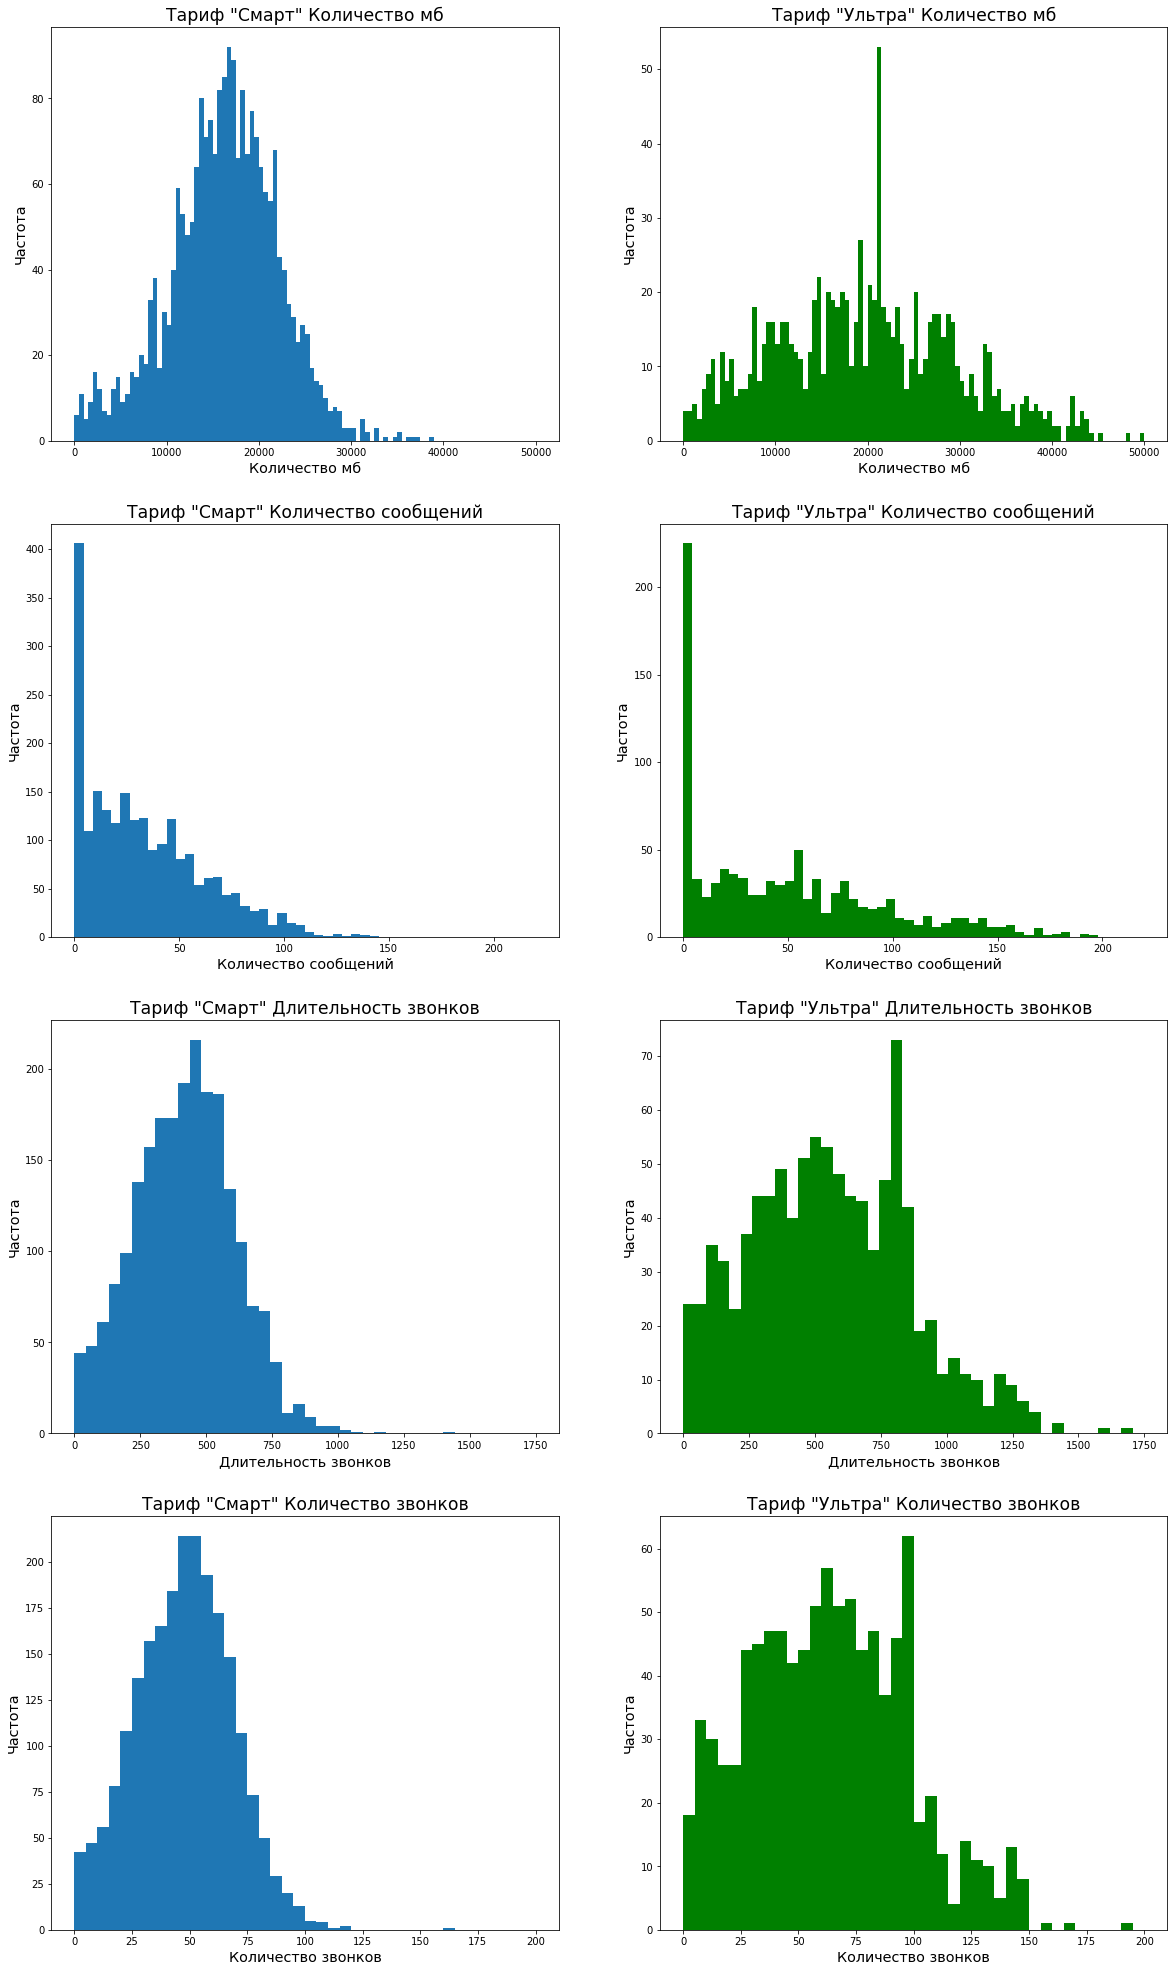

In [38]:
plt.figure(figsize=(20,35))
targer_columns=['mb_count','messages_count','duration_sum_per_month','calls_count_per_month']
titles=['Количество мб','Количество сообщений','Длительность звонков','Количество звонков']
ranges=[(0,50000),(0,220),(0,1750),(0,200)]
bins_c=[100,50,40,40]
l=0
k=1
for col_name in targer_columns:
    plt.subplot(len(targer_columns),2,k)
    plt.hist(data_smart[col_name],range=ranges[l],bins=bins_c[l])
    name='Тариф "Смарт" '+titles[l]
    plt.title(name,fontsize='xx-large')
    plt.xlabel(titles[l],fontsize='x-large')
    plt.ylabel('Частота',fontsize='x-large')
    
    plt.subplot(len(targer_columns),2,k+1)
    plt.hist(data_ultra[col_name],range=ranges[l],bins=bins_c[l],color='green')
    name='Тариф "Ультра" '+titles[l]
    plt.title(name,fontsize='xx-large')
    plt.xlabel(titles[l],fontsize='x-large')
    plt.ylabel('Частота',fontsize='x-large')
    k+=2
    l+=1

Распределение количества мб напомнимает нормально распределение, видно, что мало используются смс, остальные два напоминают симметричное распределение. 

Теперь посчитаем дисперсию, среднее и стандартное отклонение для столбцов 'Количество мб','Количество сообщений','Длительность звонков','Количество звонков'. Конечно, у нас уже есть эти данные выше в describe(), но проделаем это для тренировки.

In [39]:
targer_columns=['mb_count','messages_count','duration_sum_per_month','calls_count_per_month']
titles=['Количество мб','Количество сообщений','Длительность звонков','Количество звонков']

disp=[]
mean_=[]
std_=[]
title_col=[]
funct=['Дисперсия','Среднее','Стандартное оклонение']
for g in funct:
    i=0
    for cl_column in targer_columns:
        emp=[]
        we=[]
        if g=='Дисперсия':
            emp.append('Дисперсия')
            if cl_column=='mb_count':
                emp.append(data_ultra[cl_column].var())
                emp.append(data_smart[cl_column].var())
                emp.append(titles[i])
                t_big=emp
            else:    
                emp.append(data_ultra[cl_column].var())
                emp.append(data_smart[cl_column].var())
                emp.append(titles[i])
                disp.append(emp)
        elif g=='Среднее':
            emp.append('Среднее')
            emp.append(data_ultra[cl_column].mean())
            emp.append(data_smart[cl_column].mean())
            emp.append(titles[i])
            mean_.append(emp)
        elif g=='Стандартное оклонение':
            we.append('Стандартное оклонение')
            we.append(np.sqrt(data_ultra[cl_column].var()))
            we.append(np.sqrt(data_smart[cl_column].var()))
            we.append(titles[i])
            std_.append(we)
        i+=1

data_stats = pd.DataFrame([disp[0],disp[1],disp[2],mean_[0],mean_[1],mean_[2],mean_[3],std_[0],
                    std_[1],std_[2],std_[3]],columns=['Функция','Ультра','Смарт','Название переменной'])

print(t_big)
data_stats


['Дисперсия', 96751936.87231648, 34511766.685211666, 'Количество мб']


,Функция,Ультра,Смарт,Название переменной
0,Дисперсия,2123.393122,799.093149,Количество сообщений
1,Дисперсия,92125.568142,35672.689364,Длительность звонков
2,Дисперсия,1165.885698,435.629075,Количество звонков
3,Среднее,19752.533609,16238.773874,Количество мб
4,Среднее,49.263702,33.406757,Количество сообщений
5,Среднее,559.013444,419.606757,Длительность звонков
6,Среднее,63.038263,47.136036,Количество звонков
7,Стандартное оклонение,9836.256243,5874.671624,Количество мб
8,Стандартное оклонение,46.080290,28.268236,Количество сообщений
9,Стандартное оклонение,303.521940,188.872151,Длительность звонков


Я вынес из таблицы дисперсию Количества мб в отдельную переменную, так как она переводила все числа в формат 10e+7, что мешало анализу. Всегда можно будет получить дисперсию этой величины, взяв квадрат от стандартного отклонения.

#### Вывод
Заметим, что среднее использование своих возможностей у абонентов Ультра больше, однако больше стандартное отклонение(поэтому гистограммы и шире). Большинству пользователей Смартра не хватает отведенных им 15гб интернета. Среднее надодится больше 15гб => очень много людей переплачивают за интернет. У остальных переменных в среднем никто не использует больше отведенного им лимита(у пользователей ультра нет ни одной дополнительной минуты и сообщения). 

### Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; (Гипотеза 1)
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов; (Гипотеза 1)

#### Средняя выручка пользователей

Составим нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова;   
**Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;**  
Проверим это:

In [40]:
alpha = .05
print('Дисперсия "Смарт":',data_smart['profit'].var())
print('Дисперсия "Ультра":',data_ultra['profit'].var())
results = st.ttest_ind(
    data_smart['profit'], 
    data_ultra['profit'],equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия "Смарт": 675487.7113258144
Дисперсия "Ультра": 143829.49443434586
p-значение: 2.8973713561831406e-242
Отвергаем нулевую гипотезу


Нулевая гипотеза ошибочна, слишком маленькое значение. Поэтому делаем вывод, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

#### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Составим нулевую гипотезу: Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;  
**Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;** 

Для начала составим две таблицы: с москвичами и нет.

In [41]:
data_Moscow=data[data['city']=='Москва']
data_Moscow.head()

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff,city,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
8,1001,18452,0.0,430,45,smart,Москва,550,0.0,0,800,1350.0
9,1001,14053,0.0,414,47,smart,Москва,550,0.0,0,0,550.0
17,1003,8571,37.0,380,43,ultra,Москва,1950,0.0,0,0,1950.0
18,1003,12479,91.0,961,105,ultra,Москва,1950,0.0,0,0,1950.0
19,1003,14779,83.0,855,97,ultra,Москва,1950,0.0,0,0,1950.0


In [42]:
data_others=data[data['city']!='Москва']
data_others.head()

,user_id,mb_count,messages_count,duration_sum_per_month,calls_count_per_month,tariff,city,rub_monthly_fee,profit_from_message,profit_from_calls,profit_from_internet,profit
0,1000,2256,22.0,159,17,ultra,Краснодар,1950,0.0,0,0,1950.0
1,1000,23257,60.0,172,28,ultra,Краснодар,1950,0.0,0,0,1950.0
2,1000,14016,75.0,340,41,ultra,Краснодар,1950,0.0,0,0,1950.0
3,1000,14070,81.0,408,42,ultra,Краснодар,1950,0.0,0,0,1950.0
4,1000,14581,57.0,466,46,ultra,Краснодар,1950,0.0,0,0,1950.0


In [43]:
print('Дисперсия Москвы:',data_Moscow['profit'].var())
print('Дисперсия других:',data_others['profit'].var())

results = st.ttest_ind(
    data_Moscow['profit'], 
    data_others['profit'],equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия Москвы: 547392.1451877934
Дисперсия других: 663869.446284787
p-значение: 0.15507037836031343
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя прибыль, с вероятностью в почти 16% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними прибылями.

#### Вывод
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается ("Ультима" прибыльнее)
- Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

### Шаг 5. Напишем общий вывод

Мы посмотрели информацию о предоставленных нам данных, выявили ошибки, исправили их, сгруппировали их по пользователям и месяцам и объединили в единую таблицу <a href="#1">Ссылка на объединенную таблицу</a>  
С помощью этой таблицы мы посчитали прибыль с каждого пользователя и занесли это в таблицу <a href="#2">Ссылка на объединенную таблицу с выручкой</a>  
По этой таблице мы построили графики распределения минут разговора, сообщений и объёма интернет-трафика используемого пользователями <a href="#3">Графики</a>
Получили таблицу со статистическими данными

In [44]:
data_stats

,Функция,Ультра,Смарт,Название переменной
0,Дисперсия,2123.393122,799.093149,Количество сообщений
1,Дисперсия,92125.568142,35672.689364,Длительность звонков
2,Дисперсия,1165.885698,435.629075,Количество звонков
3,Среднее,19752.533609,16238.773874,Количество мб
4,Среднее,49.263702,33.406757,Количество сообщений
5,Среднее,559.013444,419.606757,Длительность звонков
6,Среднее,63.038263,47.136036,Количество звонков
7,Стандартное оклонение,9836.256243,5874.671624,Количество мб
8,Стандартное оклонение,46.080290,28.268236,Количество сообщений
9,Стандартное оклонение,303.521940,188.872151,Длительность звонков


С помощью гипотез мы выяснили, что
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается ("Ультима" прибыльнее)
- Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов